# Classification

In [9]:
# Loading all the modules that I will use in this notebook
from itertools import product
import cudf, cuml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest,SelectFromModel, f_classif
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from cuml.neighbors import KNeighborsClassifier as knnCM
from cuml.ensemble import RandomForestClassifier as rfCM

### 1. Load Data

In [13]:
# Loading the train, test and validation data(datasets) + looking the first 5 rows of the train dataset as confirmation that the data is loaded
train = pd.read_csv('../input/classification/classification/train/videos_emg_features_05_01_train.csv')
validation = pd.read_csv('../input/classification/classification/validation/videos_emg_features_05_01_validation.csv')
test = pd.read_csv('../input/classification/classification/test/videos_emg_features_05_01_test.csv')
train.head()

,Subject,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,...,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,video,arousal,valence,class
0,Subject 26,0.000693,0.000002,-0.294017,0.193476,-0.557275,0.585870,0.294017,-0.221918,0.433606,...,2.467522e-15,6.193481e-13,175910.121778,175910.121778,1.136194,3.597469e-07,GroupA\01,4.0,5.0,neutral
1,Subject 26,0.000678,0.000001,-0.226482,0.115931,-0.460327,0.567215,0.226482,-0.129059,0.400917,...,2.244050e-15,5.632566e-13,178406.356796,178406.356796,1.132120,3.404466e-07,GroupA\01,4.0,5.0,neutral
2,Subject 26,0.000646,0.000001,-0.211141,0.078928,-0.399045,0.543397,0.211141,-0.087260,0.364224,...,2.276071e-15,5.712938e-13,195627.240519,195627.240519,1.143079,3.235088e-07,GroupA\01,4.0,5.0,neutral
3,Subject 26,0.000645,0.000001,-0.194372,0.068487,-0.398650,0.522556,0.194372,-0.075143,0.368694,...,2.158618e-15,5.418131e-13,195613.944335,195613.944335,1.141087,3.025860e-07,GroupA\01,4.0,5.0,neutral
4,Subject 26,0.000667,0.000001,-0.202488,0.095966,-0.396178,0.539132,0.202488,-0.105682,0.354309,...,2.189921e-15,5.496702e-13,186209.998678,186209.998678,1.135205,2.963975e-07,GroupA\01,4.0,5.0,neutral


### 2. Basic Data Exploration

In [4]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136900 entries, 0 to 136899
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 253.8+ MB


In [5]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the validation dataset
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34022 entries, 0 to 34021
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 63.1+ MB


In [6]:
# Basic info about the size(rows+colums) of the dataset, the memory usage and the datatypes of the data in the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30791 entries, 0 to 30790
Columns: 243 entries, Subject to class
dtypes: float64(240), object(3)
memory usage: 57.1+ MB


In [7]:
# The names of the columns(features) of the train dataset(basically they are same for the train, validation and test datasets)
print(train.columns.to_list())

['Subject', '0_iav', '0_aac', '0_ar1', '0_ar2', '0_ar3', '0_ar4', '0_cc1', '0_cc2', '0_cc3', '0_cc4', '0_dasdv', '0_kurt', '0_log', '0_mav1', '0_mav2', '0_mav', '0_mhw', '0_mtw', '0_rms', '0_skew', '0_ssi', '0_tm', '0_var', '0_v_order', '0_wl', '0_mnf', '0_mdf', '0_pkf', '0_mnp', '0_ttp', '0_vcf', '0_psr', '0_ohm', '0_maxx', '1_iav', '1_aac', '1_ar1', '1_ar2', '1_ar3', '1_ar4', '1_cc1', '1_cc2', '1_cc3', '1_cc4', '1_dasdv', '1_kurt', '1_log', '1_mav1', '1_mav2', '1_mav', '1_mhw', '1_mtw', '1_rms', '1_skew', '1_ssi', '1_tm', '1_var', '1_v_order', '1_wl', '1_mnf', '1_mdf', '1_pkf', '1_mnp', '1_ttp', '1_vcf', '1_psr', '1_ohm', '1_maxx', '2_iav', '2_aac', '2_ar1', '2_ar2', '2_ar3', '2_ar4', '2_cc1', '2_cc2', '2_cc3', '2_cc4', '2_dasdv', '2_kurt', '2_log', '2_mav1', '2_mav2', '2_mav', '2_mhw', '2_mtw', '2_rms', '2_skew', '2_ssi', '2_tm', '2_var', '2_v_order', '2_wl', '2_mnf', '2_mdf', '2_pkf', '2_mnp', '2_ttp', '2_vcf', '2_psr', '2_ohm', '2_maxx', '3_iav', '3_aac', '3_ar1', '3_ar2', '3_ar3'

In [8]:
# The datatypes of each feature
print(train.dtypes.to_list())

[dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'

In [9]:
# All the features which datatype is object(string)
print(train.select_dtypes(include=['object']).columns.to_list())

['Subject', 'video', 'class']


In [10]:
# The shape of the train, validation, test datasets(number of rows + colums)
print(train.shape)
print(validation.shape)
print(test.shape)

(136900, 243)
(34022, 243)
(30791, 243)


In [12]:
# Some basic statistics about the train dataset(for every feature)
train.describe()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,arousal,valence
count,136900.000000,1.369000e+05,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,136900.000000,...,136900.000000,136900.000000,1.369000e+05,1.369000e+05,136900.000000,136900.000000,136900.000000,1.369000e+05,136900.000000,136900.000000
mean,0.000962,2.011216e-06,-0.271099,0.044827,-0.468986,0.479032,0.271099,-0.052796,0.424350,-0.796404,...,797.182504,643.969365,8.603373e-15,2.159447e-12,226518.552672,226518.552672,1.124445,3.803549e-07,4.027392,4.858254
std,0.001095,2.205904e-06,0.055585,0.129302,0.162632,0.278002,0.055585,0.148736,0.090637,0.497404,...,167.655869,200.395509,6.309540e-14,1.583695e-11,73350.152853,73350.152853,0.021839,5.015984e-07,2.387450,2.051504
min,0.000079,5.298191e-22,-0.646185,-1.010335,-1.278402,-0.188837,-0.770062,-0.843842,-0.528635,-4.527535,...,30.720000,0.000000,4.815219e-47,1.208620e-44,10376.386606,10376.386606,1.000986,1.018363e-07,1.000000,1.000000
25%,0.000457,1.126037e-06,-0.306377,-0.046400,-0.548088,0.259662,0.238753,-0.136083,0.363811,-1.185796,...,665.600000,522.240000,5.877735e-16,1.475311e-13,160450.658424,160450.658424,1.109027,1.668098e-07,2.000000,3.000000
50%,0.000647,1.410171e-06,-0.273208,0.025893,-0.429214,0.482127,0.273208,-0.029235,0.426405,-0.750072,...,747.520000,604.160000,1.228682e-15,3.083992e-13,237748.170152,237748.170152,1.124208,2.363802e-07,4.000000,5.000000
75%,0.001081,2.093361e-06,-0.238753,0.118917,-0.360350,0.700024,0.306377,0.052279,0.487836,-0.401789,...,911.360000,706.560000,4.271765e-15,1.072213e-12,287975.965854,287975.965854,1.138832,4.407158e-07,6.000000,6.000000
max,0.034699,7.104418e-05,0.770062,0.748818,0.935470,1.840554,0.646185,0.694043,0.973251,0.359982,...,2549.760000,2560.000000,2.593379e-12,6.509381e-10,882278.729335,882278.729335,1.750818,1.194507e-05,9.000000,9.000000


In [13]:
# Looking if there are any NaN/Null values in the train dataset
train.isna().sum().sum()

0

In [14]:
# Looking if there are any NaN/Null values in the validation dataset
validation.isna().sum().sum()

0

In [15]:
# Looking if there are any NaN/Null values in the test dataset
test.isna().sum().sum()

0

### 3. EDA, Visualization

In [16]:
# Getting the unique values of the valence column from the train dataset
valences=train["valence"]
unique_valences, num_examples_per_valence = np.unique(valences, return_counts = True)
unique_valences

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [17]:
# Getting the unique values of the class column from the train dataset
classes=train["class"]
unique_classes, num_examples_per_class = np.unique(classes, return_counts = True)
unique_classes

array(['negative', 'neutral', 'positive'], dtype=object)

In [19]:
# Calculating the percentages of how many entries are negative, neutral and positive(from the class)
negative_perc=num_examples_per_class[0]/(num_examples_per_class.sum())*100
positive_perc=num_examples_per_class[2]/(num_examples_per_class.sum())*100
neutral_perc=num_examples_per_class[1]/(num_examples_per_class.sum())*100
neutral_perc

53.21183345507669

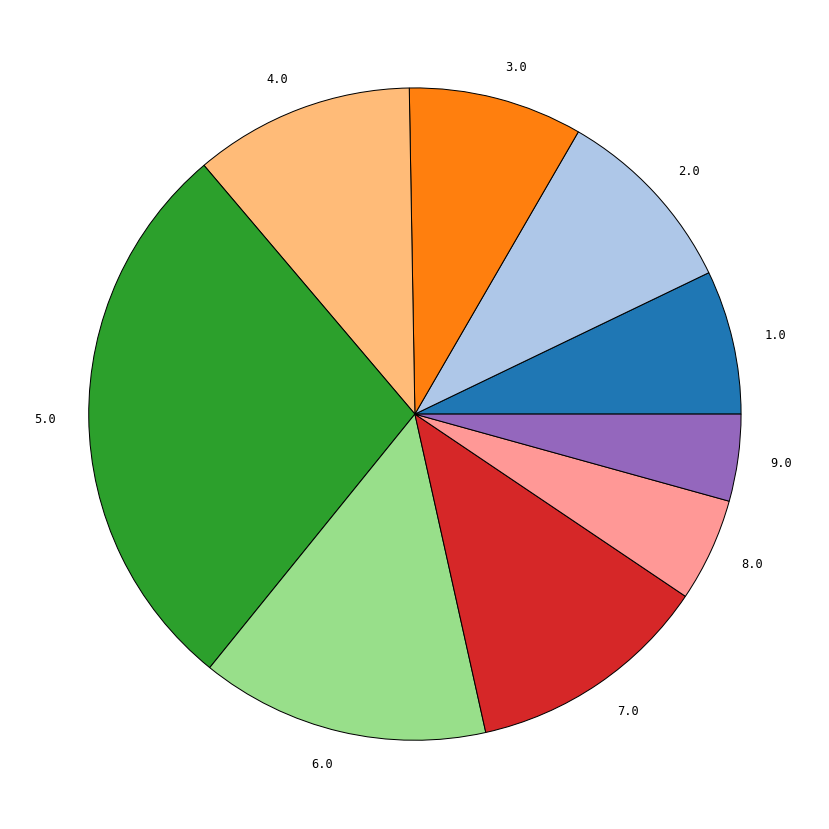

In [20]:
# Plotting the distribution of the valence per entries
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))

# define the color palette which we will use
cmap = plt.get_cmap("tab20")
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_valence))]

# use the pie chart function in the pyplot module to visualize the activity distributions
ax.pie(x = num_examples_per_valence, 
       colors = sampled_colors,
       labels = unique_valences, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

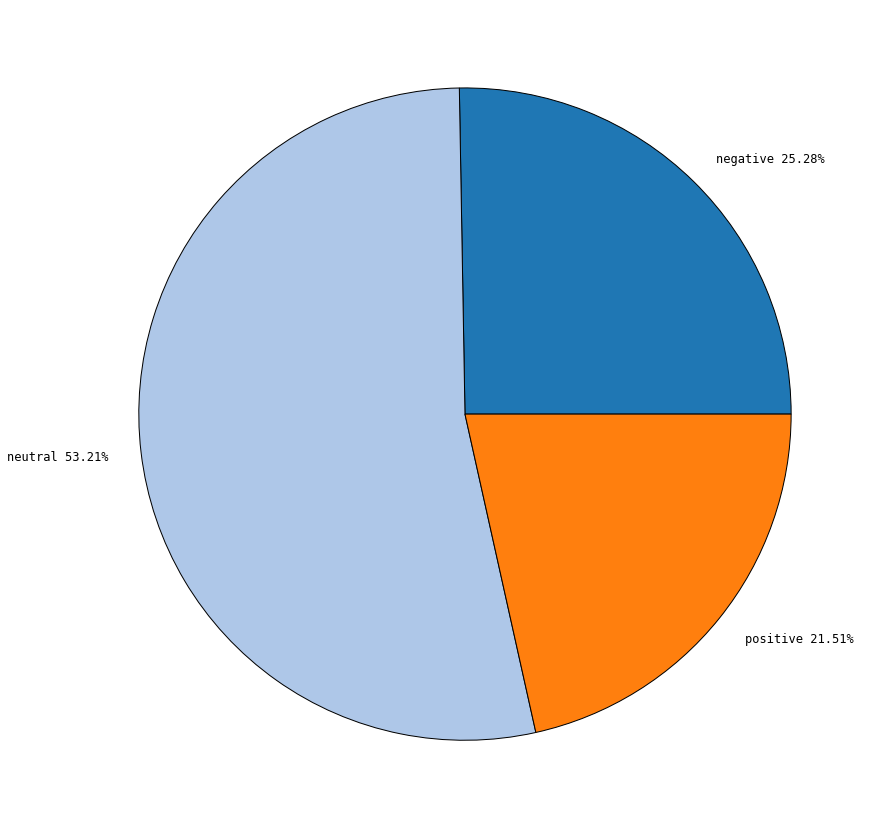

In [21]:
# Plotting the distribution of classes per entry
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 15))
# define the color palette which we will use
cmap = plt.get_cmap("tab20")
neg= "{:.2f}".format(negative_perc)
neut= "{:.2f}".format(neutral_perc)
pos = "{:.2f}".format(positive_perc)
my_labels=['','','']
my_labels[0]=unique_classes[0]+" "+str(neg)+"%"
my_labels[1]=unique_classes[1]+" "+str(neut)+"%"
my_labels[2]=unique_classes[2]+" "+str(pos)+"%"
# sample as many colors from the palette as there are unique activites, so that each activity will be represented by a different color
sampled_colors = [cmap(i) for i in range (len(num_examples_per_class))]
ax.pie(x = num_examples_per_class, 
       colors = sampled_colors,
       labels = my_labels, 
       wedgeprops= {'linewidth': 1, 
                    'edgecolor': 'black'}, 
       textprops = {'size': 'large', 
                    'family': "monospace",
                    'weight': 'medium'} 
);

### 4. Data Preprocessing + Data Split

In [14]:
# From the train dataset dropping all the columns(info) about the subject, video, arousal, valence
train = train.drop(['Subject' ,'video', 'arousal', 'valence'], axis = 1)
train.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,class
0,0.000693,0.000002,-0.294017,0.193476,-0.557275,0.585870,0.294017,-0.221918,0.433606,-0.966924,...,777.582881,604.16,491.52,2.467522e-15,6.193481e-13,175910.121778,175910.121778,1.136194,3.597469e-07,neutral
1,0.000678,0.000001,-0.226482,0.115931,-0.460327,0.567215,0.226482,-0.129059,0.400917,-0.908324,...,795.819529,634.88,583.68,2.244050e-15,5.632566e-13,178406.356796,178406.356796,1.132120,3.404466e-07,neutral
2,0.000646,0.000001,-0.211141,0.078928,-0.399045,0.543397,0.211141,-0.087260,0.364224,-0.840275,...,798.745054,593.92,583.68,2.276071e-15,5.712938e-13,195627.240519,195627.240519,1.143079,3.235088e-07,neutral
3,0.000645,0.000001,-0.194372,0.068487,-0.398650,0.522556,0.194372,-0.075143,0.368694,-0.811550,...,804.709039,655.36,583.68,2.158618e-15,5.418131e-13,195613.944335,195613.944335,1.141087,3.025860e-07,neutral
4,0.000667,0.000001,-0.202488,0.095966,-0.396178,0.539132,0.202488,-0.105682,0.354309,-0.825662,...,803.127950,665.60,573.44,2.189921e-15,5.496702e-13,186209.998678,186209.998678,1.135205,2.963975e-07,neutral


In [15]:
# From the validation dataset dropping all the columns(info) about the subject, video, arousal, valence
validation = validation.drop(['Subject' ,'video', 'arousal', 'valence'], axis = 1)
validation.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,class
0,0.000441,0.000001,-0.334551,0.017524,-0.348620,0.210088,0.334551,-0.020455,0.341489,-0.317702,...,1089.883827,993.28,532.48,5.839758e-16,1.465779e-13,284079.951714,284079.951714,1.113174,1.632425e-07,positive
1,0.000470,0.000001,-0.345069,0.022060,-0.273772,0.259987,0.345069,-0.025867,0.266691,-0.363991,...,1012.890525,829.44,532.48,6.813120e-16,1.710093e-13,301391.185259,301391.185259,1.137440,1.735655e-07,positive
2,0.000466,0.000001,-0.358741,0.042098,-0.279966,0.276975,0.358741,-0.049649,0.266066,-0.387515,...,1043.770519,870.40,532.48,6.865532e-16,1.723249e-13,317636.011109,317636.011109,1.136466,1.828983e-07,positive
3,0.000442,0.000001,-0.267404,0.049737,-0.361819,0.248929,0.267404,-0.056387,0.341417,-0.376413,...,1107.718475,1003.52,542.72,6.021871e-16,1.511490e-13,318048.430724,318048.430724,1.122141,1.671134e-07,positive
4,0.000429,0.000001,-0.250008,0.032683,-0.337250,0.266309,0.250008,-0.036769,0.324850,-0.396075,...,1105.282820,1013.76,1280.00,6.032106e-16,1.514059e-13,300760.143538,300760.143538,1.116330,1.739748e-07,positive


In [16]:
# From the test dataset dropping all the columns(info) about the subject, video, arousal, valence
test = test.drop(['Subject' ,'video', 'arousal', 'valence'], axis = 1)
test.head()

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx,class
0,0.000477,0.000001,-0.282164,-0.073709,-0.465545,0.166727,0.282164,0.084108,0.504701,-0.292948,...,1106.773055,993.28,655.36,5.752697e-16,1.443927e-13,280006.027260,280006.027260,1.108416,1.696260e-07,neutral
1,0.000465,0.000001,-0.262964,-0.079181,-0.462096,0.194851,0.262964,0.089592,0.503496,-0.342010,...,1127.921677,1013.76,655.36,5.502947e-16,1.381240e-13,291634.642456,291634.642456,1.108709,1.731016e-07,neutral
2,0.000429,0.000001,-0.244149,-0.062111,-0.436960,0.172627,0.244149,0.069693,0.467413,-0.293659,...,1119.944004,1003.52,655.36,5.418429e-16,1.360026e-13,271807.048776,271807.048776,1.103043,1.606352e-07,neutral
3,0.000427,0.000001,-0.283302,-0.008829,-0.449354,0.224499,0.283302,0.010080,0.453883,-0.377344,...,1148.386357,1044.48,665.60,5.544107e-16,1.391571e-13,267030.478892,267030.478892,1.096577,1.659668e-07,neutral
4,0.000417,0.000001,-0.254080,-0.033362,-0.428612,0.231616,0.254080,0.037600,0.444728,-0.386125,...,1136.543983,1013.76,665.60,5.200007e-16,1.305202e-13,271600.712459,271600.712459,1.100119,1.642974e-07,neutral


In [17]:
# The train data is all the columns except the last column which is the class
X_train = train.iloc[:,:-1]
X_train

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000693,0.000002,-0.294017,0.193476,-0.557275,0.585870,0.294017,-0.221918,0.433606,-0.966924,...,-4.712230e-06,777.582881,604.16,491.52,2.467522e-15,6.193481e-13,175910.121778,175910.121778,1.136194,3.597469e-07
1,0.000678,0.000001,-0.226482,0.115931,-0.460327,0.567215,0.226482,-0.129059,0.400917,-0.908324,...,-2.219070e-06,795.819529,634.88,583.68,2.244050e-15,5.632566e-13,178406.356796,178406.356796,1.132120,3.404466e-07
2,0.000646,0.000001,-0.211141,0.078928,-0.399045,0.543397,0.211141,-0.087260,0.364224,-0.840275,...,4.887581e-06,798.745054,593.92,583.68,2.276071e-15,5.712938e-13,195627.240519,195627.240519,1.143079,3.235088e-07
3,0.000645,0.000001,-0.194372,0.068487,-0.398650,0.522556,0.194372,-0.075143,0.368694,-0.811550,...,7.152557e-07,804.709039,655.36,583.68,2.158618e-15,5.418131e-13,195613.944335,195613.944335,1.141087,3.025860e-07
4,0.000667,0.000001,-0.202488,0.095966,-0.396178,0.539132,0.202488,-0.105682,0.354309,-0.825662,...,5.165736e-07,803.127950,665.60,573.44,2.189921e-15,5.496702e-13,186209.998678,186209.998678,1.135205,2.963975e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136895,0.000516,0.000001,-0.362316,0.014572,-0.336977,0.353298,0.362316,-0.017212,0.331177,-0.528804,...,-1.788162e-07,970.297467,870.40,532.48,1.159675e-15,2.910785e-13,236097.357271,236097.357271,1.118380,2.229397e-07
136896,0.000527,0.000001,-0.347752,0.014216,-0.346542,0.401977,0.347752,-0.016688,0.340758,-0.607442,...,-1.792161e-06,956.605358,819.20,624.64,1.128472e-15,2.832464e-13,251853.292594,251853.292594,1.129257,2.375530e-07
136897,0.000532,0.000001,-0.389285,0.031756,-0.374169,0.393635,0.389285,-0.037937,0.359974,-0.606184,...,-2.642475e-06,936.343407,788.48,532.48,1.201034e-15,3.014595e-13,250166.091238,250166.091238,1.133727,2.462810e-07
136898,0.000525,0.000001,-0.411930,0.052148,-0.392349,0.395622,0.411930,-0.062889,0.367674,-0.613813,...,-4.533975e-06,938.880738,737.28,450.56,1.143954e-15,2.871324e-13,270763.326829,270763.326829,1.143312,2.026677e-07


In [18]:
# The class for the train data is the last column
y_train = train.iloc[:,-1]
y_train

0          neutral
1          neutral
2          neutral
3          neutral
4          neutral
            ...   
136895    positive
136896    positive
136897    positive
136898    positive
136899    positive
Name: class, Length: 136900, dtype: object

In [19]:
# The validation data is all the columns except the last column which is the class
X_validation = validation.iloc[:,:-1]
X_validation

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000441,0.000001,-0.334551,0.017524,-0.348620,0.210088,0.334551,-0.020455,0.341489,-0.317702,...,-2.519672e-06,1089.883827,993.28,532.48,5.839758e-16,1.465779e-13,284079.951714,284079.951714,1.113174,1.632425e-07
1,0.000470,0.000001,-0.345069,0.022060,-0.273772,0.259987,0.345069,-0.025867,0.266691,-0.363991,...,-2.524838e-06,1012.890525,829.44,532.48,6.813120e-16,1.710093e-13,301391.185259,301391.185259,1.137440,1.735655e-07
2,0.000466,0.000001,-0.358741,0.042098,-0.279966,0.276975,0.358741,-0.049649,0.266066,-0.387515,...,2.019187e-06,1043.770519,870.40,532.48,6.865532e-16,1.723249e-13,317636.011109,317636.011109,1.136466,1.828983e-07
3,0.000442,0.000001,-0.267404,0.049737,-0.361819,0.248929,0.267404,-0.056387,0.341417,-0.376413,...,2.324842e-06,1107.718475,1003.52,542.72,6.021871e-16,1.511490e-13,318048.430724,318048.430724,1.122141,1.671134e-07
4,0.000429,0.000001,-0.250008,0.032683,-0.337250,0.266309,0.250008,-0.036769,0.324850,-0.396075,...,9.845659e-08,1105.282820,1013.76,1280.00,6.032106e-16,1.514059e-13,300760.143538,300760.143538,1.116330,1.739748e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34017,0.000723,0.000002,-0.319766,0.026889,-0.560346,0.317735,0.319766,-0.031188,0.542870,-0.576469,...,-4.588549e-06,1067.403952,1013.76,798.72,1.587567e-15,3.984793e-13,230911.959153,230911.959153,1.096663,2.798654e-07
34018,0.000837,0.000002,-0.313002,0.042930,-0.481843,0.370989,0.313002,-0.049648,0.457921,-0.625814,...,1.723964e-07,1104.600618,1024.00,686.08,1.489861e-15,3.739552e-13,240956.652418,240956.652418,1.094295,2.749026e-07
34019,0.000908,0.000002,-0.148813,-0.103651,-0.242217,0.311284,0.148813,0.111363,0.269191,-0.436976,...,5.352461e-06,1115.519141,1013.76,849.92,1.428781e-15,3.586240e-13,230218.115760,230218.115760,1.088580,2.779582e-07
34020,0.000872,0.000002,-0.155239,-0.100510,-0.232381,0.321751,0.155239,0.108311,0.257551,-0.446052,...,8.625256e-07,1103.095271,1013.76,849.92,1.205931e-15,3.026887e-13,251503.807192,251503.807192,1.098494,2.616199e-07


In [20]:
# The class for the validation data is the last column
y_validation = validation.iloc[:,-1]
y_validation

0        positive
1        positive
2        positive
3        positive
4        positive
           ...   
34017     neutral
34018     neutral
34019     neutral
34020     neutral
34021     neutral
Name: class, Length: 34022, dtype: object

In [21]:
# The test data is all the columns except the last column which is the class
X_test = test.iloc[:,:-1]
X_test

,0_iav,0_aac,0_ar1,0_ar2,0_ar3,0_ar4,0_cc1,0_cc2,0_cc3,0_cc4,...,6_wl,6_mnf,6_mdf,6_pkf,6_mnp,6_ttp,6_vcf,6_psr,6_ohm,6_maxx
0,0.000477,1.211073e-06,-0.282164,-0.073709,-0.465545,0.166727,0.282164,0.084108,0.504701,-0.292948,...,2.924024e-06,1106.773055,993.28,655.36,5.752697e-16,1.443927e-13,280006.027260,280006.027260,1.108416,1.696260e-07
1,0.000465,1.164340e-06,-0.262964,-0.079181,-0.462096,0.194851,0.262964,0.089592,0.503496,-0.342010,...,-6.643470e-07,1127.921677,1013.76,655.36,5.502947e-16,1.381240e-13,291634.642456,291634.642456,1.108709,1.731016e-07
2,0.000429,1.100598e-06,-0.244149,-0.062111,-0.436960,0.172627,0.244149,0.069693,0.467413,-0.293659,...,2.531475e-06,1119.944004,1003.52,655.36,5.418429e-16,1.360026e-13,271807.048776,271807.048776,1.103043,1.606352e-07
3,0.000427,1.070966e-06,-0.283302,-0.008829,-0.449354,0.224499,0.283302,0.010080,0.453883,-0.377344,...,2.197901e-06,1148.386357,1044.48,665.60,5.544107e-16,1.391571e-13,267030.478892,267030.478892,1.096577,1.659668e-07
4,0.000417,1.051405e-06,-0.254080,-0.033362,-0.428612,0.231616,0.254080,0.037600,0.444728,-0.386125,...,1.938682e-06,1136.543983,1013.76,665.60,5.200007e-16,1.305202e-13,271600.712459,271600.712459,1.100119,1.642974e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30786,0.000378,9.782695e-07,-0.200098,-0.094488,-0.394690,0.114856,0.200098,0.103941,0.435715,-0.189922,...,3.077239e-07,1109.602126,1003.52,512.00,3.801815e-16,9.542556e-14,293369.805483,293369.805483,1.112779,1.265193e-07
30787,0.000387,9.882117e-07,-0.176761,-0.052263,-0.418838,0.167116,0.176761,0.056882,0.442662,-0.278080,...,3.008856e-06,1095.440043,1003.52,512.00,4.053952e-16,1.017542e-13,297765.497411,297765.497411,1.117202,1.223218e-07
30788,0.000415,1.043870e-06,-0.173375,-0.044805,-0.490658,0.187141,0.173375,0.048689,0.514548,-0.331580,...,-3.388402e-07,1043.734078,911.36,522.24,4.317347e-16,1.083654e-13,284341.209554,284341.209554,1.122948,1.411798e-07
30789,0.000401,1.021297e-06,-0.189029,-0.056490,-0.484879,0.185424,0.189029,0.061829,0.514858,-0.328624,...,-1.996970e-06,1043.507844,911.36,675.84,4.404827e-16,1.105612e-13,300924.020520,300924.020520,1.129758,1.484544e-07


In [22]:
# The class for the test data is the last column
y_test = test.iloc[:,-1]
y_test

0        neutral
1        neutral
2        neutral
3        neutral
4        neutral
          ...   
30786    neutral
30787    neutral
30788    neutral
30789    neutral
30790    neutral
Name: class, Length: 30791, dtype: object

In [23]:
# Scaling all the data between -1 and 1 for the train, validation and test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [32]:
# Looking if the scaling is correct
X_train

array([[-0.24540104, -0.21596799, -0.41232066, ..., -0.68995924,
         0.53794104, -0.04108482],
       [-0.25918974, -0.2425503 ,  0.80269015, ..., -0.65592735,
         0.35142568, -0.07956262],
       [-0.28853612, -0.27618817,  1.07867706, ..., -0.42115011,
         0.85319842, -0.11333027],
       ...,
       [-0.39212772, -0.37525386, -2.12625464, ...,  0.32239367,
         0.42499856, -0.26729437],
       [-0.39826287, -0.37469205, -2.5336474 , ...,  0.60320168,
         0.86389756, -0.3542432 ],
       [-0.38691838, -0.36342298, -2.56660051, ...,  0.2944681 ,
         1.17734165, -0.34654639]])

In [24]:
# Encoding the classes 
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_validation = encoder.transform(y_validation)
y_test = encoder.transform(y_test)

In [34]:
# What are the encoded classes
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

### 5. Training first models

In [35]:
# Defining the basic models from which we are going to start all with basic paramethers
dc = DecisionTreeClassifier()
rf = rfCM()
xgb = XGBClassifier(tree_method = 'gpu_hist')
knn = knnCM()

In [33]:
# Function that will give as all the information of how our model is performing
def score(y_true, pred):
    f1_micro = f1_score(y_true, pred,average='micro')
    f1_macro = f1_score(y_true, pred,average='macro')                       
    print(classification_report(y_true, pred))
    print("--------------------")
    print(f'The accuracy of the model is: {accuracy_score(y_true, pred)}')
    print("--------------------")
    print(f'The f1-micro score for the model is: {f1_micro}')
    print("--------------------")
    print(f'The f1-macro score for the model is: {f1_macro}')
    print("--------------------")
    print(confusion_matrix(y_true, pred))

In [40]:
# Training the DecisionTreeClassifier model
dc.fit(X_train, y_train)

DecisionTreeClassifier()

In [42]:
# Training the RandomForestClassifier model
rf.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
# Training the XGBClassifier model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [44]:
# Training the Kneighborsclassifier model
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
# Doing the predictions for the DecisionTree model and seeing the score how the model is performing
pred_dc = dc.predict(X_validation)
score(y_validation, pred_dc)

              precision    recall  f1-score   support

           0       0.19      0.35      0.24      5552
           1       0.72      0.46      0.56     23230
           2       0.24      0.41      0.30      5240

    accuracy                           0.43     34022
   macro avg       0.38      0.40      0.37     34022
weighted avg       0.56      0.43      0.47     34022

--------------------
The accuracy of the model is: 0.4344835694550585
--------------------
The f1-micro score for the model is: 0.4344835694550585
--------------------
The f1-macro score for the model is: 0.36905510260245267
--------------------
[[ 1928  2263  1361]
 [ 7002 10730  5498]
 [ 1289  1827  2124]]


In [49]:
# Doing the predictions for the RandomForest model and seeing the score how the model is performing
pred_rf = rf.predict(X_validation)
score(y_validation, pred_rf)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.34      0.41      0.37      5552
           1       0.80      0.65      0.72     23230
           2       0.32      0.50      0.39      5240

    accuracy                           0.59     34022
   macro avg       0.48      0.52      0.49     34022
weighted avg       0.65      0.59      0.61     34022

--------------------
The accuracy of the model is: 0.5903826935512315
--------------------
The f1-micro score for the model is: 0.5903826935512315
--------------------
The f1-macro score for the model is: 0.49335983496329355
--------------------
[[ 2273  1988  1291]
 [ 3755 15168  4307]
 [  696  1899  2645]]


In [50]:
# Doing the predictions for the XGBoost model and seeing the score how the model is performing
pred_xgb = xgb.predict(X_validation)
score(y_validation, pred_xgb)

              precision    recall  f1-score   support

           0       0.29      0.38      0.32      5552
           1       0.77      0.60      0.67     23230
           2       0.30      0.49      0.37      5240

    accuracy                           0.55     34022
   macro avg       0.45      0.49      0.46     34022
weighted avg       0.62      0.55      0.57     34022

--------------------
The accuracy of the model is: 0.5457938980659574
--------------------
The f1-micro score for the model is: 0.5457938980659574
--------------------
The f1-macro score for the model is: 0.4557683781679138
--------------------
[[ 2086  2248  1218]
 [ 4528 13936  4766]
 [  699  1994  2547]]


In [51]:
# Doing the predictions for the KNN model and seeing the score how the model is performing
pred_knn = knn.predict(X_validation)
score(y_validation, pred_knn)

              precision    recall  f1-score   support

           0       0.26      0.49      0.34      5552
           1       0.76      0.54      0.63     23230
           2       0.25      0.34      0.29      5240

    accuracy                           0.50     34022
   macro avg       0.42      0.45      0.42     34022
weighted avg       0.60      0.50      0.53     34022

--------------------
The accuracy of the model is: 0.5014990300393862
--------------------
The f1-micro score for the model is: 0.5014990300393862
--------------------
The f1-macro score for the model is: 0.41964159686306984
--------------------
[[ 2705  1832  1015]
 [ 6473 12600  4157]
 [ 1259  2224  1757]]


### 6. Feature Extraction

In [25]:
# Doing feature selecting and getting the best 200 features and transforming the train and validation data to remove the bad features
fs1 = SelectKBest(f_classif, k=200)
X_train_fs1 = fs1.fit_transform(X_train, y_train)
X_validation_fs1 = fs1.transform(X_validation)

In [53]:
# Doing feature selecting and getting the best 100 features and transforming the train and validation data to remove the bad features
fs2 = SelectKBest(f_classif, k=100)
X_train_fs2 = fs2.fit_transform(X_train, y_train)
X_validation_fs2 = fs2.transform(X_validation)

In [54]:
# The shape of the new train, validation datasets(number of rows + colums)
print(X_train_fs1.shape)
print(X_validation_fs1.shape)
print(X_train_fs2.shape)
print(X_validation_fs2.shape)

(136900, 200)
(34022, 200)
(136900, 100)
(34022, 100)


In [55]:
# Training the DecisionTreeClassifier model with the new data with 200 features
dc.fit(X_train_fs1, y_train)

DecisionTreeClassifier()

In [58]:
# Training the RandomForestClassifier model with the new data with 200 features
rf.fit(X_train_fs1, y_train)

RandomForestClassifier()

In [57]:
# Training the XGBClassifier model with the new data with 200 features
xgb.fit(X_train_fs1, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [59]:
# Training the XGBClassifier model with the new data with 200 features
knn.fit(X_train_fs1, y_train)

KNeighborsClassifier()

In [60]:
# Doing the predictions for the DecisionTree model and seeing the score how the model is performing with the data with 200 features
pred_dc_fs1 = dc.predict(X_validation_fs1)
score(y_validation, pred_dc_fs1)

              precision    recall  f1-score   support

           0       0.20      0.36      0.25      5552
           1       0.72      0.48      0.58     23230
           2       0.23      0.39      0.29      5240

    accuracy                           0.44     34022
   macro avg       0.39      0.41      0.37     34022
weighted avg       0.56      0.44      0.48     34022

--------------------
The accuracy of the model is: 0.44403621186291226
--------------------
The f1-micro score for the model is: 0.44403621186291226
--------------------
The f1-macro score for the model is: 0.3738380649945885
--------------------
[[ 1978  2121  1453]
 [ 6904 11097  5229]
 [ 1118  2090  2032]]


In [61]:
# Doing the predictions for the RandomForest model and seeing the score how the model is performing with the data with 200 features
pred_rf_fs1 = rf.predict(X_validation_fs1)
score(y_validation, pred_rf_fs1)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.31      0.37      0.34      5552
           1       0.78      0.65      0.71     23230
           2       0.32      0.49      0.39      5240

    accuracy                           0.58     34022
   macro avg       0.47      0.50      0.48     34022
weighted avg       0.63      0.58      0.60     34022

--------------------
The accuracy of the model is: 0.5826230086414673
--------------------
The f1-micro score for the model is: 0.5826230086414673
--------------------
The f1-macro score for the model is: 0.4798574038093218
--------------------
[[ 2058  2277  1217]
 [ 3871 15201  4158]
 [  660  2017  2563]]


In [62]:
# Doing the predictions for the XGBoost model and seeing the score how the model is performing with the data with 200 features
pred_xgb_fs1 = xgb.predict(X_validation_fs1)
score(y_validation, pred_xgb_fs1)

              precision    recall  f1-score   support

           0       0.28      0.39      0.32      5552
           1       0.77      0.61      0.68     23230
           2       0.30      0.47      0.37      5240

    accuracy                           0.55     34022
   macro avg       0.45      0.49      0.46     34022
weighted avg       0.62      0.55      0.57     34022

--------------------
The accuracy of the model is: 0.5487625653988596
--------------------
The f1-micro score for the model is: 0.5487625653988596
--------------------
The f1-macro score for the model is: 0.4565670128287925
--------------------
[[ 2143  2077  1332]
 [ 4878 14084  4268]
 [  699  2098  2443]]


In [63]:
# Doing the predictions for the KNN model and seeing the score how the model is performing with the data with 200 features
pred_knn_fs1 = knn.predict(X_validation_fs1)
score(y_validation, pred_knn_fs1)

              precision    recall  f1-score   support

           0       0.25      0.48      0.33      5552
           1       0.76      0.54      0.63     23230
           2       0.25      0.34      0.29      5240

    accuracy                           0.50     34022
   macro avg       0.42      0.45      0.41     34022
weighted avg       0.60      0.50      0.53     34022

--------------------
The accuracy of the model is: 0.49535594615248957
--------------------
The f1-micro score for the model is: 0.49535594615248957
--------------------
The f1-macro score for the model is: 0.41420193414983525
--------------------
[[ 2638  1826  1088]
 [ 6604 12454  4172]
 [ 1311  2168  1761]]


In [64]:
# Training the DecisionTreeClassifier model with the new data with 100 features
dc.fit(X_train_fs2, y_train)

DecisionTreeClassifier()

In [66]:
# Training the RandomForestClassifier model with the new data with 100 features
rf.fit(X_train_fs2, y_train)

RandomForestClassifier()

In [67]:
# Training the XGBClassifier model with the new data with 100 features
xgb.fit(X_train_fs2, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [68]:
# Training the XGBClassifier model with the new data with 100 features
knn.fit(X_train_fs2, y_train)

KNeighborsClassifier()

In [69]:
# Doing the predictions for the DecisionTree model and seeing the score how the model is performing with the data with 100 features
pred_dc_fs2 = dc.predict(X_validation_fs2)
score(y_validation, pred_dc_fs2)

              precision    recall  f1-score   support

           0       0.19      0.37      0.25      5552
           1       0.72      0.47      0.57     23230
           2       0.24      0.37      0.29      5240

    accuracy                           0.44     34022
   macro avg       0.38      0.41      0.37     34022
weighted avg       0.56      0.44      0.48     34022

--------------------
The accuracy of the model is: 0.4416553994474164
--------------------
The f1-micro score for the model is: 0.4416553994474164
--------------------
The f1-macro score for the model is: 0.37263930967189335
--------------------
[[ 2034  2129  1389]
 [ 7422 11032  4776]
 [ 1063  2217  1960]]


In [70]:
# Doing the predictions for the RandomForest model and seeing the score how the model is performing with the data with 100 features
pred_rf_fs2 = rf.predict(X_validation_fs2)
score(y_validation, pred_rf_fs2)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.20      0.28      0.23      5552
           1       0.74      0.64      0.69     23230
           2       0.36      0.43      0.39      5240

    accuracy                           0.55     34022
   macro avg       0.43      0.45      0.44     34022
weighted avg       0.59      0.55      0.57     34022

--------------------
The accuracy of the model is: 0.5466168949503263
--------------------
The f1-micro score for the model is: 0.5466168949503263
--------------------
The f1-macro score for the model is: 0.4357214474264879
--------------------
[[ 1558  2801  1193]
 [ 5594 14808  2828]
 [  670  2339  2231]]


In [71]:
# Doing the predictions for the XGBoost model and seeing the score how the model is performing with the data with 100 features
pred_xgb_fs2 = xgb.predict(X_validation_fs2)
score(y_validation,pred_xgb_fs2)

              precision    recall  f1-score   support

           0       0.22      0.32      0.26      5552
           1       0.74      0.62      0.67     23230
           2       0.31      0.37      0.34      5240

    accuracy                           0.53     34022
   macro avg       0.42      0.44      0.43     34022
weighted avg       0.59      0.53      0.56     34022

--------------------
The accuracy of the model is: 0.5342425489389219
--------------------
The f1-micro score for the model is: 0.5342425489389219
--------------------
The f1-macro score for the model is: 0.42535018667134133
--------------------
[[ 1800  2561  1191]
 [ 5705 14419  3106]
 [  717  2566  1957]]


In [72]:
# Doing the predictions for the KNN model and seeing the score how the model is performing with the data with 100 features
pred_knn_fs2 = knn.predict(X_validation_fs2)
score(y_validation,pred_knn_fs2)

              precision    recall  f1-score   support

           0       0.22      0.41      0.29      5552
           1       0.74      0.56      0.64     23230
           2       0.26      0.30      0.28      5240

    accuracy                           0.50     34022
   macro avg       0.41      0.43      0.40     34022
weighted avg       0.58      0.50      0.53     34022

--------------------
The accuracy of the model is: 0.4963552995120804
--------------------
The f1-micro score for the model is: 0.4963552995120804
--------------------
The f1-macro score for the model is: 0.40186314930069605
--------------------
[[ 2304  2120  1128]
 [ 6828 13002  3400]
 [ 1326  2333  1581]]


We are going to use the data with the 200 features, because we are not losing too much accuracy for the predictions for each model + we are getting on speed for training the models

In [74]:
print(knn.get_params())

{'handle': <cuml.raft.common.handle.Handle object at 0x7f832a9f41f0>, 'verbose': 4, 'output_type': 'input', 'n_neighbors': 5, 'algorithm': 'auto', 'metric': 'euclidean', 'p': 2, 'metric_params': None, 'algo_params': None, 'weights': 'uniform'}


### 7. Hyperparameter optimization

### 7.1 Automated

In [11]:
# Function for training a model with certain parameters and testing that model on validation data + scoring the model and returs all the results into a dictionary
def hypOpt(classificator, param):
    model = classificator(**param)
    model.fit(X_train_fs1, y_train)
    pred = model.predict(X_validation_fs1)
    f1_micro = f1_score(y_validation, pred, average = 'micro')
    f1_macro = f1_score(y_validation, pred, average = 'macro')
    print('Model finished !')  
    print("--------------------")
    dict = {}
    dict['model'] = model.__class__.__name__
    dict['parameters']= model.get_params()
    dict['f1_score_micro'] = f1_micro
    dict['f1_score_macro'] = f1_macro
    return dict

In [6]:
# Function that iterates through the different combinations of parameters for a particular model(classificator) + puts the result into a list
def listResult(classificator, parameters):
    results = list()
    for para in parameters:
        result = hypOpt(classificator, para)
        results.append(result)
    return results
    

In [77]:
# Function that creates a different combination of parameters for RandomForestClassifier(list of parameters)
def paramRF():
    max_depth = [32, 64, 100]
    split_criterion = [0, 1]
    n_estimators = [500, 1000, 1500, 2000]
    n_bins = [256, 512]
    parameters = list()
    for max_depth, split_criterion, n_estimators, n_bins in product(max_depth, split_criterion, n_estimators, n_bins):
        param = {'max_depth': max_depth, 'split_criterion': split_criterion, 'n_estimators': n_estimators, 'n_bins': n_bins}
        parameters.append(param)
    return parameters

In [4]:
# Function that creates a different combination of parameters for KNN(list of parameters)
# 370 is a number that comes from one formula which is n = sqrt(number_of_entries_in_the_data)
# cuML allows only changing the n_neighbors parameter
def paramKNN():
    n_neighbors = [50,100,200,300,370,400,500]
    parameters = list()
    for n_neighbor in n_neighbors:
        param = {'n_neighbors': n_neighbor}
        parameters.append(param)
    return parameters

In [79]:
# Function that creates a different combination of parameters for XGB(list of parameters)
def paramXGB():
    verbosity = [0]
    tree_method = ['gpu_hist']
    max_depth = [3, 6, 7, None]
    n_estimators = [500, 1000, 1500, 2000]
    booster=['gbtree', 'dart']
    parameters = list()
    for verbosity,tree_method, max_depth, n_estimators, booster in product(verbosity, tree_method, max_depth, n_estimators, booster):
        param = {'verbosity': verbosity, 'tree_method': tree_method, 'max_depth': max_depth, 'n_estimators': n_estimators, 'booster': booster}
        parameters.append(param)
    return parameters

In [ ]:
# Training + predicting + scoring all the RandomForest models(NOT ENOUGH RAM)
parameters = paramRF()
print("--------------------")
print('There are '+ str(len(parameters)) + ' combination of different parameters !')
print("--------------------")
results_rf = listResult(rfCM, parameters)

--------------------
There are 48 combination of different parameters !
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Model finished !
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Model finished !
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Model finished !
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Model finished !
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


Model finished !
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


In [ ]:
df_rf = pd.DataFrame(results_rf)
df_rf.head(10)
df_rf.to_csv('./results_rf.csv')

In [ ]:
# Training + predicting + scoring all the XGB models(NOT ENOUGH RAM)
parameters = paramXGB()
print("--------------------")
print('There are '+ str(len(parameters)) + ' combination of different parameters !')
print("--------------------")
results_xgb = listResult(XGBClassifier, parameters, len(parameters))

In [ ]:
df_xgb = pd.DataFrame(results_xgb)
df_xgb.head(10)
df_xgb.to_csv('./results_xgb.csv')

### ONLY KNN HYPERPARA OPT IS DONE WITH FUNCTIONS

In [26]:
# Training + predicting + scoring all the KNN models
parameters = paramKNN()
print("--------------------")
print('There are '+ str(len(parameters)) + ' combination of different parameters !')
print("--------------------")
results_knn = listResult(knnCM, parameters)

--------------------
There are 7 combination of different parameters !
--------------------
Model finished !
--------------------
Model finished !
--------------------
Model finished !
--------------------
Model finished !
--------------------
Model finished !
--------------------
Model finished !
--------------------
Model finished !
--------------------


In [30]:
# Creating dataframe of all the results
df_knn = pd.DataFrame(results_knn)
df_knn.head(10)

,model,parameters,f1_score_micro,f1_score_macro
0,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.582505,0.480102
1,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.613515,0.503990
2,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.637852,0.521052
3,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.651049,0.527835
4,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.658368,0.532686
5,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.660661,0.534105
6,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.665628,0.536478


In [ ]:
# Saving the dataframe to output
df_knn.to_csv('./results_knn.csv')

### 7.2 Manual

### FROM HERE STARTS XGBOOST

In [71]:
results = list()

In [72]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'gbtree')
xgb.fit(X_train_fs1,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [73]:
pred = xgb.predict(X_validation_fs1)
score(y_validation, pred)

              precision    recall  f1-score   support

           0       0.27      0.36      0.31      5552
           1       0.77      0.60      0.68     23230
           2       0.29      0.45      0.35      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.45     34022
weighted avg       0.61      0.54      0.57     34022

--------------------
The accuracy of the model is: 0.5416495208982424
--------------------
The f1-micro score for the model is: 0.5416495208982424
--------------------
The f1-macro score for the model is: 0.4457131429656833
--------------------
[[ 2006  2120  1426]
 [ 4810 14042  4378]
 [  747  2113  2380]]


In [74]:
dict = {}
dict['model'] = xgb.__class__.__name__
dict['parameters']= xgb.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [75]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 1000, booster = 'gbtree')
xgb.fit(X_train_fs1,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [76]:
pred = xgb.predict(X_validation_fs1)
score(y_validation, pred)

              precision    recall  f1-score   support

           0       0.26      0.35      0.30      5552
           1       0.77      0.61      0.68     23230
           2       0.29      0.45      0.35      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.44     34022
weighted avg       0.61      0.54      0.57     34022

--------------------
The accuracy of the model is: 0.5405913820469108
--------------------
The f1-micro score for the model is: 0.5405913820469108
--------------------
The f1-macro score for the model is: 0.44313001844918737
--------------------
[[ 1970  2189  1393]
 [ 4817 14073  4340]
 [  799  2092  2349]]


In [77]:
dict = {}
dict['model'] = xgb.__class__.__name__
dict['parameters']= xgb.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [78]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart')
xgb.fit(X_train_fs1,y_train)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [79]:
pred = xgb.predict(X_validation_fs1)
score(y_validation, pred)

              precision    recall  f1-score   support

           0       0.27      0.36      0.31      5552
           1       0.77      0.60      0.68     23230
           2       0.29      0.45      0.35      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.45     34022
weighted avg       0.61      0.54      0.57     34022

--------------------
The accuracy of the model is: 0.5416495208982424
--------------------
The f1-micro score for the model is: 0.5416495208982424
--------------------
The f1-macro score for the model is: 0.4457131429656833
--------------------
[[ 2006  2120  1426]
 [ 4810 14042  4378]
 [  747  2113  2380]]


In [80]:
dict = {}
dict['model'] = xgb.__class__.__name__
dict['parameters']= xgb.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [85]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart', max_depth=5)
xgb.fit(X_train_fs1,y_train)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [86]:
pred = xgb.predict(X_validation_fs1)
score(y_validation, pred)

              precision    recall  f1-score   support

           0       0.26      0.40      0.31      5552
           1       0.77      0.58      0.66     23230
           2       0.28      0.43      0.34      5240

    accuracy                           0.52     34022
   macro avg       0.44      0.47      0.44     34022
weighted avg       0.61      0.52      0.55     34022

--------------------
The accuracy of the model is: 0.5245723355475869
--------------------
The f1-micro score for the model is: 0.5245723355475869
--------------------
The f1-macro score for the model is: 0.43735042118985934
--------------------
[[ 2207  1952  1393]
 [ 5479 13375  4376]
 [  862  2113  2265]]


In [87]:
dict = {}
dict['model'] = xgb.__class__.__name__
dict['parameters']= xgb.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [88]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart', max_depth=7)
xgb.fit(X_train_fs1,y_train)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [89]:
pred = xgb.predict(X_validation_fs1)
score(y_validation, pred)

              precision    recall  f1-score   support

           0       0.27      0.38      0.31      5552
           1       0.77      0.60      0.67     23230
           2       0.29      0.44      0.35      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.44     34022
weighted avg       0.61      0.54      0.56     34022

--------------------
The accuracy of the model is: 0.5379166421727117
--------------------
The f1-micro score for the model is: 0.5379166421727117
--------------------
The f1-macro score for the model is: 0.4444107403797868
--------------------
[[ 2105  2120  1327]
 [ 4937 13889  4404]
 [  800  2133  2307]]


In [90]:
dict = {}
dict['model'] = xgb.__class__.__name__
dict['parameters']= xgb.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [91]:
df_xgb = pd.DataFrame(results)
df_xgb.head()

,model,parameters,f1_score_micro,f1_score_macro
0,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.541650,0.445713
1,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.540591,0.443130
2,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.541650,0.445713
3,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.524572,0.437350
4,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.537917,0.444411


In [92]:
df_xgb.to_csv('./results_xgb.csv')

### FROM HERE STARTS RANDOMFOREST

In [93]:
results = list()

In [94]:
rf = rfCM(n_estimators=500)
rf.fit(X_train_fs1,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

In [95]:
pred = rf.predict(X_validation_fs1)
score(y_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.33      0.39      0.36      5552
           1       0.79      0.65      0.71     23230
           2       0.32      0.50      0.39      5240

    accuracy                           0.59     34022
   macro avg       0.48      0.51      0.49     34022
weighted avg       0.64      0.59      0.61     34022

--------------------
The accuracy of the model is: 0.5869143495385339
--------------------
The f1-micro score for the model is: 0.5869143495385339
--------------------
The f1-macro score for the model is: 0.487662272845532
--------------------
[[ 2177  2122  1253]
 [ 3780 15177  4273]
 [  647  1979  2614]]


In [96]:
dict = {}
dict['model'] = rf.__class__.__name__
dict['parameters']= rf.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [97]:
rf = rfCM(n_estimators=1000)
rf.fit(X_train_fs1,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

In [98]:
pred = rf.predict(X_validation_fs1)
score(y_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.33      0.38      0.35      5552
           1       0.79      0.65      0.71     23230
           2       0.32      0.50      0.39      5240

    accuracy                           0.59     34022
   macro avg       0.48      0.51      0.49     34022
weighted avg       0.64      0.59      0.61     34022

--------------------
The accuracy of the model is: 0.5867967785550526
--------------------
The f1-micro score for the model is: 0.5867967785550526
--------------------
The f1-macro score for the model is: 0.48670997716224146
--------------------
[[ 2129  2173  1250]
 [ 3705 15198  4327]
 [  645  1958  2637]]


In [99]:
dict = {}
dict['model'] = rf.__class__.__name__
dict['parameters']= rf.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [100]:
rf = rfCM(n_estimators=500, n_bins = 256, split_criterion= 1)
rf.fit(X_train_fs1,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

In [101]:
pred = rf.predict(X_validation_fs1)
score(y_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.33      0.42      0.37      5552
           1       0.80      0.64      0.71     23230
           2       0.33      0.52      0.40      5240

    accuracy                           0.59     34022
   macro avg       0.49      0.53      0.49     34022
weighted avg       0.65      0.59      0.61     34022

--------------------
The accuracy of the model is: 0.588119452119217
--------------------
The f1-micro score for the model is: 0.588119452119217
--------------------
The f1-macro score for the model is: 0.4949669628835793
--------------------
[[ 2309  1973  1270]
 [ 3933 14982  4315]
 [  654  1868  2718]]


In [102]:
dict = {}
dict['model'] = rf.__class__.__name__
dict['parameters']= rf.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [103]:
rf = rfCM(n_estimators=500, n_bins = 256, split_criterion= 0)
rf.fit(X_train_fs1,y_train)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:567: UserWarning: To use pickling or GPU-based prediction first train using float32 data to fit the estimator
  ret_val = func(*args, **kwargs)


RandomForestClassifier()

In [104]:
pred = rf.predict(X_validation_fs1)
score(y_validation, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.32      0.40      0.36      5552
           1       0.79      0.64      0.71     23230
           2       0.32      0.50      0.39      5240

    accuracy                           0.58     34022
   macro avg       0.48      0.51      0.48     34022
weighted avg       0.64      0.58      0.60     34022

--------------------
The accuracy of the model is: 0.5812415495855623
--------------------
The f1-micro score for the model is: 0.5812415495855623
--------------------
The f1-macro score for the model is: 0.4846618687068107
--------------------
[[ 2197  2099  1256]
 [ 3943 14953  4334]
 [  659  1956  2625]]


In [105]:
dict = {}
dict['model'] = rf.__class__.__name__
dict['parameters']= rf.get_params()
dict['f1_score_micro'] = f1_score(y_validation, pred, average='micro')
dict['f1_score_macro'] = f1_score(y_validation, pred, average='macro')
results.append(dict)

In [106]:
df_rf = pd.DataFrame(results)
df_rf.head()

,model,parameters,f1_score_micro,f1_score_macro
0,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.586914,0.487662
1,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.586797,0.486710
2,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.588119,0.494967
3,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.581242,0.484662


In [107]:
df_rf.to_csv('./results_rf.csv')

### 8. Final models + results

In [111]:
df = pd.concat([df_rf,df_xgb,df_knn],  ignore_index=True)
df.head(16)

,model,parameters,f1_score_micro,f1_score_macro
0,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.586914,0.487662
1,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.586797,0.486710
2,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.588119,0.494967
3,RandomForestClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.581242,0.484662
4,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.541650,0.445713
5,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.540591,0.443130
6,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.541650,0.445713
7,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.524572,0.437350
8,XGBClassifier,"{'objective': 'multi:softprob', 'use_label_enc...",0.537917,0.444411
9,KNeighborsClassifier,{'handle': <cuml.raft.common.handle.Handle obj...,0.582505,0.480102


In [112]:
df.to_csv('./results.csv')

In [114]:
X_test_fs1 = fs1.transform(X_test)

In [118]:
rf = rfCM(df.iloc[2].parameters)
rf.fit(X_train_fs1,y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass split_criterion={'handle': <cuml.raft.common.handle.Handle object at 0x7fca80789e10>, 'verbose': 4, 'output_type': 'input', 'n_estimators': 500, 'max_depth': 16, 'max_features': 'auto', 'n_bins': 256, 'split_criterion': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'max_samples': 1.0, 'max_leaves': -1, 'accuracy_metric': None, 'max_batch_size': 4096, 'n_streams': 4, 'dtype': dtype('float64'), 'min_weight_fraction_leaf': None, 'n_jobs': None, 'max_leaf_nodes': None, 'min_impurity_split': None, 'oob_score': None, 'random_state': None, 'warm_start': None, 'class_weight': None, 'criterion': None} as keyword args. From version 21.06, passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: The split criterion chos

RandomForestClassifier()

In [119]:
pred = rf.predict(X_validation_fs1)
score(y_validation, pred)
print("--------------------")
pred = rf.predict(X_test_fs1)
score(y_test, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.31      0.37      0.34      5552
           1       0.78      0.65      0.71     23230
           2       0.32      0.49      0.39      5240

    accuracy                           0.58     34022
   macro avg       0.47      0.50      0.48     34022
weighted avg       0.63      0.58      0.60     34022

--------------------
The accuracy of the model is: 0.5826230086414673
--------------------
The f1-micro score for the model is: 0.5826230086414673
--------------------
The f1-macro score for the model is: 0.4798574038093218
--------------------
[[ 2058  2277  1217]
 [ 3871 15201  4158]
 [  660  2017  2563]]
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.18      0.15      0.16      7117
           1       0.65      0.66      0.66     19330
           2       0.46      0.54      0.49      4344

    accuracy                           0.53     30791
   macro avg       0.43      0.45      0.44     30791
weighted avg       0.51      0.53      0.52     30791

--------------------
The accuracy of the model is: 0.5265174888766198
--------------------
The f1-micro score for the model is: 0.5265174888766198
--------------------
The f1-macro score for the model is: 0.4370669011221824
--------------------
[[ 1043  5057  1017]
 [ 4738 12826  1766]
 [  114  1887  2343]]


In [120]:
rf = rfCM(df.iloc[2].parameters)
rf.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass split_criterion={'handle': <cuml.raft.common.handle.Handle object at 0x7fca80789e10>, 'verbose': 4, 'output_type': 'input', 'n_estimators': 500, 'max_depth': 16, 'max_features': 'auto', 'n_bins': 256, 'split_criterion': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'max_samples': 1.0, 'max_leaves': -1, 'accuracy_metric': None, 'max_batch_size': 4096, 'n_streams': 4, 'dtype': dtype('float64'), 'min_weight_fraction_leaf': None, 'n_jobs': None, 'max_leaf_nodes': None, 'min_impurity_split': None, 'oob_score': None, 'random_state': None, 'warm_start': None, 'class_weight': None, 'criterion': None} as keyword args. From version 21.06, passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:794: UserWarning: The split criterion chos

RandomForestClassifier()

In [121]:
pred = rf.predict(X_validation)
score(y_validation, pred)
print("--------------------")
pred = rf.predict(X_test)
score(y_test, pred)

/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.34      0.41      0.37      5552
           1       0.80      0.65      0.72     23230
           2       0.32      0.50      0.39      5240

    accuracy                           0.59     34022
   macro avg       0.48      0.52      0.49     34022
weighted avg       0.65      0.59      0.61     34022

--------------------
The accuracy of the model is: 0.5903826935512315
--------------------
The f1-micro score for the model is: 0.5903826935512315
--------------------
The f1-macro score for the model is: 0.49335983496329355
--------------------
[[ 2273  1988  1291]
 [ 3755 15168  4307]
 [  696  1899  2645]]
--------------------


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:586: UserWarning: GPU based predict only accepts np.float32 data. The model was trained on np.float64 data hence cannot use GPU-based prediction! 
Defaulting to CPU-based Prediction. 
To predict on float-64 data, set parameter predict_model = 'CPU'
  ret_val = func(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.16      0.13      0.14      7117
           1       0.65      0.66      0.65     19330
           2       0.46      0.54      0.50      4344

    accuracy                           0.52     30791
   macro avg       0.42      0.44      0.43     30791
weighted avg       0.51      0.52      0.51     30791

--------------------
The accuracy of the model is: 0.5217108895456465
--------------------
The f1-micro score for the model is: 0.5217108895456465
--------------------
The f1-macro score for the model is: 0.4300632963925088
--------------------
[[  905  5165  1047]
 [ 4778 12801  1751]
 [  108  1878  2358]]


In [129]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart')
xgb.fit(X_train_fs1, y_train)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [130]:
pred = xgb.predict(X_validation_fs1)
score(y_validation, pred)
print("--------------------")
pred = xgb.predict(X_test_fs1)
score(y_test, pred)

              precision    recall  f1-score   support

           0       0.27      0.36      0.31      5552
           1       0.77      0.60      0.68     23230
           2       0.29      0.45      0.35      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.45     34022
weighted avg       0.61      0.54      0.57     34022

--------------------
The accuracy of the model is: 0.5416495208982424
--------------------
The f1-micro score for the model is: 0.5416495208982424
--------------------
The f1-macro score for the model is: 0.4457131429656833
--------------------
[[ 2006  2120  1426]
 [ 4810 14042  4378]
 [  747  2113  2380]]
--------------------
              precision    recall  f1-score   support

           0       0.29      0.27      0.28      7117
           1       0.65      0.54      0.59     19330
           2       0.27      0.50      0.35      4344

    accuracy                           0.47     30791
   macro avg     

In [131]:
xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators = 500, booster = 'dart')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [132]:
pred = xgb.predict(X_validation)
score(y_validation, pred)
print("--------------------")
pred = xgb.predict(X_test)
score(y_test, pred)

              precision    recall  f1-score   support

           0       0.26      0.37      0.31      5552
           1       0.76      0.60      0.67     23230
           2       0.29      0.44      0.35      5240

    accuracy                           0.54     34022
   macro avg       0.44      0.47      0.44     34022
weighted avg       0.61      0.54      0.56     34022

--------------------
The accuracy of the model is: 0.5361530774204927
--------------------
The f1-micro score for the model is: 0.5361530774204927
--------------------
The f1-macro score for the model is: 0.44269800076166993
--------------------
[[ 2058  2185  1309]
 [ 4954 13854  4422]
 [  760  2151  2329]]
--------------------
              precision    recall  f1-score   support

           0       0.27      0.28      0.28      7117
           1       0.64      0.54      0.59     19330
           2       0.29      0.48      0.36      4344

    accuracy                           0.47     30791
   macro avg    

In [124]:
knn = knnCM(n_neighbors = 370)
knn.fit(X_train_fs1, y_train)

KNeighborsClassifier()

In [125]:
pred = knn.predict(X_validation_fs1)
score(y_validation, pred)
print("--------------------")
pred = knn.predict(X_test_fs1)
score(y_test, pred)

              precision    recall  f1-score   support

           0       0.44      0.43      0.43      5552
           1       0.79      0.77      0.78     23230
           2       0.36      0.41      0.39      5240

    accuracy                           0.66     34022
   macro avg       0.53      0.54      0.53     34022
weighted avg       0.67      0.66      0.66     34022

--------------------
The accuracy of the model is: 0.6583681147492799
--------------------
The f1-micro score for the model is: 0.6583681147492799
--------------------
The f1-macro score for the model is: 0.5326859499383085
--------------------
[[ 2370  2220   962]
 [ 2499 17867  2864]
 [  486  2592  2162]]
--------------------
              precision    recall  f1-score   support

           0       0.14      0.18      0.16      7117
           1       0.60      0.54      0.57     19330
           2       0.45      0.48      0.46      4344

    accuracy                           0.44     30791
   macro avg     

In [126]:
knn = knnCM(n_neighbors = 370)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [128]:
pred = knn.predict(X_validation)
score(y_validation, pred)
print("--------------------")
pred = knn.predict(X_test)
score(y_test, pred)

              precision    recall  f1-score   support

           0       0.45      0.39      0.42      5552
           1       0.78      0.77      0.78     23230
           2       0.36      0.42      0.39      5240

    accuracy                           0.66     34022
   macro avg       0.53      0.53      0.53     34022
weighted avg       0.66      0.66      0.66     34022

--------------------
The accuracy of the model is: 0.656163658809006
--------------------
The f1-micro score for the model is: 0.656163658809006
--------------------
The f1-macro score for the model is: 0.5271024677900246
--------------------
[[ 2189  2354  1009]
 [ 2312 17928  2990]
 [  408  2625  2207]]
--------------------
              precision    recall  f1-score   support

           0       0.14      0.16      0.15      7117
           1       0.60      0.55      0.58     19330
           2       0.46      0.49      0.48      4344

    accuracy                           0.45     30791
   macro avg       